In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_root = project_root / "neuralbi_diff" / "gbi_diff"
code_root = project_root / "neuralbi_diff"
sys.path.extend([str(project_root), str(code_root)])
print(sys.path)

['/home/robin/miniconda3/envs/gbi/lib/python312.zip', '/home/robin/miniconda3/envs/gbi/lib/python3.12', '/home/robin/miniconda3/envs/gbi/lib/python3.12/lib-dynload', '', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/neuralbi_diff']


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import Guidance
from gbi_diff.sampling.utils import load_observed_data
from gbi_diff.utils.criterion import SBICriterion
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.metrics import compute_distances, mse_dist
from gbi_diff.sampling.diffusion import DiffusionSampler
from gbi_diff.utils.configs.sampling_diffusion import Config
from sourcerer.simulators import TwoMoonsSimulator

# specify matplotlib rc file
plt.style.use(str(project_root / ".matplotlibrc"))


In [3]:
guidance_ckpt = str(project_root) + "/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-26-15-31-19/lightning_logs/version_0/epoch=64-step=2600.ckpt"
guidance_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_guidance/two_moons/2025-03-26-17-46-02/lightning_logs/version_0/epoch=99-step=4000.ckpt"
guidance = Guidance.load_from_checkpoint(guidance_ckpt)

In [4]:
x, theta = load_observed_data("../data/two_moons_1000.pt")
dist_matrix = compute_distances(mse_dist, x, x)

Compute mse_dist distances: 100%|██████████| 1000/1000 [00:00<00:00, 20896.61sample/s]


Text(0.5, 0.98, 'Two Moons, Observation Space')

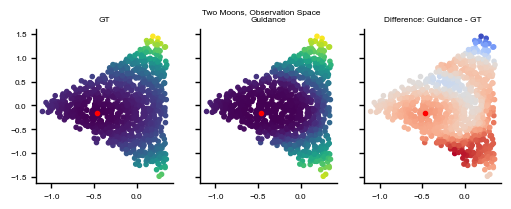

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(6, 2))

idx = 9
T = 0

with torch.no_grad():
    time_repr = guidance.get_diff_time_repr(np.ones(1) * T)
    pred_dist = guidance.forward(theta[[idx]], x[None], time_repr)

ax1.scatter(*x.T, c=dist_matrix.T[idx])
ax1.scatter(*x[idx], c="r")
ax1.set_title("GT")

ax2.scatter(*x.T, c=pred_dist.squeeze())
ax2.scatter(*x[idx], c="r")                   
ax2.set_title("Guidance")

ax3.scatter(*x.T, c=pred_dist.squeeze() - dist_matrix[idx], cmap="coolwarm")
ax3.scatter(*x[idx], c="r")                   
ax3.set_title("Difference: Guidance - GT")


fig.suptitle("Two Moons, Observation Space")

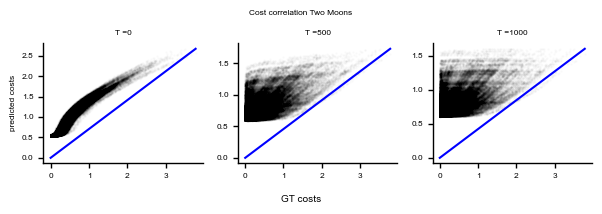

In [6]:
indices = np.arange(100)
fig, axs = plt.subplots(ncols=3, figsize=(6, 2))


for T, ax in zip([0, 500, 1000], (axs)):
    with torch.no_grad():
        time_repr = guidance.get_diff_time_repr(np.ones(len(indices)) * T)
        pred_dist = guidance.forward(theta[[indices]], x[None].repeat(len(indices), 1, 1), time_repr)

    ax.plot([0, dist_matrix[indices].max()], [0, pred_dist.max()], color="blue")
    ax.scatter(dist_matrix[indices].flatten(), pred_dist[:, :, 0].flatten(), s=1, alpha=0.01)
    ax.set_title(f"{T =}")

axs[0].set_ylabel("predicted costs")
fig.supxlabel("GT costs")
fig.suptitle("Cost correlation Two Moons")
fig.tight_layout()


In [7]:
diffusion_ckpt = "/home/robin/projects/lab_project/neuralgbi_diffusion/results/train_diffusion/two_moons/2025-03-27-01-38-46/lightning_logs/version_0/epoch=99-step=4000.ckpt"
sampler = DiffusionSampler(diffusion_ckpt, guidance_ckpt, Config.from_file("../config/sampling_diffusion.yaml"))

In [ ]:
samples = []
gammas = [10, 100, 1000]
for gamma in gammas:
    sampler.update_beta(gamma)
    samples.append(sampler.forward(1000).detach())
samples = torch.stack(samples)

Sample in observed data: 100%|██████████| 10/10 [00:54<00:00,  5.42s/it]


tensor([[[[ 0.4642,  1.0868],
          [-0.4183,  0.7161],
          [-0.8157, -0.5325],
          ...,
          [ 0.1057,  0.2358],
          [-0.6801,  0.3642],
          [ 0.8750,  0.0904]],

         [[ 0.5283,  1.0140],
          [-0.7686,  0.5910],
          [ 0.5891,  0.2998],
          ...,
          [-0.7071,  0.0800],
          [-0.8219,  0.4004],
          [ 0.4148, -0.7807]],

         [[ 0.5580,  0.6544],
          [-0.8026,  0.3345],
          [-0.6816, -0.7019],
          ...,
          [-0.2746, -0.3146],
          [-0.5043,  1.2653],
          [ 0.0230, -0.0830]],

         ...,

         [[-0.4069, -0.7187],
          [-0.3406,  1.0968],
          [-0.7054, -0.2636],
          ...,
          [-0.2748,  0.8812],
          [-0.9993,  0.9995],
          [ 0.0973, -0.1661]],

         [[ 0.2913,  0.6301],
          [-0.7675,  0.7649],
          [-0.8854, -0.4874],
          ...,
          [ 0.3241,  0.2449],
          [-0.8111,  0.9746],
          [ 0.1137, -0.5201]],



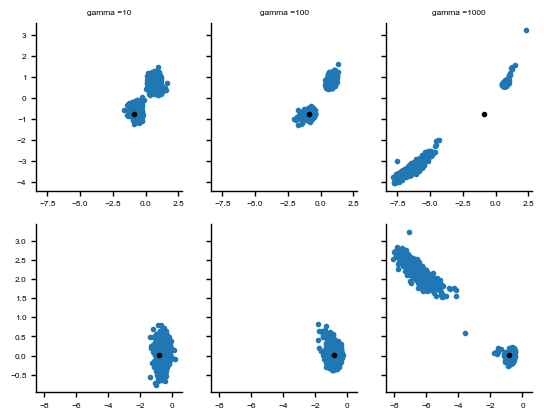

In [34]:
x, theta = load_observed_data("../data/observed_data/two_moons_10.pt")
simulator = TwoMoonsSimulator()

fig, axs = plt.subplots(ncols=3, nrows=2, sharex="row", sharey="row")

ax.scatter(*theta[0])
ax.scatter(*samples[:, 0].T)

sample_idx = 0
for idx, gamma in enumerate(gammas):
    axs[0, idx].scatter(*theta[sample_idx])
    axs[0, idx].scatter(*samples[idx, :, sample_idx].T, zorder=-1)

    axs[1, idx].scatter(*x[sample_idx])
    preds = simulator.sample(samples[idx, :, sample_idx])
    axs[1, idx].scatter(*preds.T, zorder=-1)

    axs[0, idx].set_title(f"{gamma =}")
